In [ ]:
!git clone https://github.com/misbah4064/signatureExtractor.git
%cd signatureExtractor/
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import skimage
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops

fatal: destination path 'signatureExtractor' already exists and is not an empty directory.
/content/signatureExtractor


In [ ]:
# Read Image
img = cv2.imread('cheque3.jpg', 0)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# Extract Blobs
blobs = img > img.mean()
blobs_labels = measure.label(blobs, background=1)
image_label_overlay = label2rgb(blobs_labels, image=img)

In [ ]:
# Cheque dimensions
cheque_width_cm = 18  # Width of the cheque in centimeters
cheque_height_cm = 8.5  # Height of the cheque in centimeters

# Signature region dimensions (as a percentage of cheque dimensions)
signature_width_percent = 20  # Width of the signature region as a percentage of cheque width
signature_height_percent = 15  # Height of the signature region as a percentage of cheque height

# Calculate signature region dimensions
signature_width_cm = (signature_width_percent / 100) * cheque_width_cm
signature_height_cm = (signature_height_percent / 100) * cheque_height_cm

# Calculate bounding box coordinates
signature_x = int(cheque_width_cm - signature_width_cm)  # X-coordinate of the top-left corner of the signature region
signature_y = int(cheque_height_cm - signature_height_cm)  # Y-coordinate of the top-left corner of the signature region
signature_width = int(signature_width_cm)  # Width of the signature region
signature_height = int(signature_height_cm)  # Height of the signature region

# Print the bounding box coordinates
print("Bounding box coordinates of the signature region:")
print("X:", signature_x)
print("Y:", signature_y)
print("Width:", signature_width)
print("Height:", signature_height)


Bounding box coordinates of the signature region:
X: 14
Y: 7
Width: 3
Height: 1


the_biggest_component: 15332
average: 40.167195157105795
a4_constant: 219.5452236818625


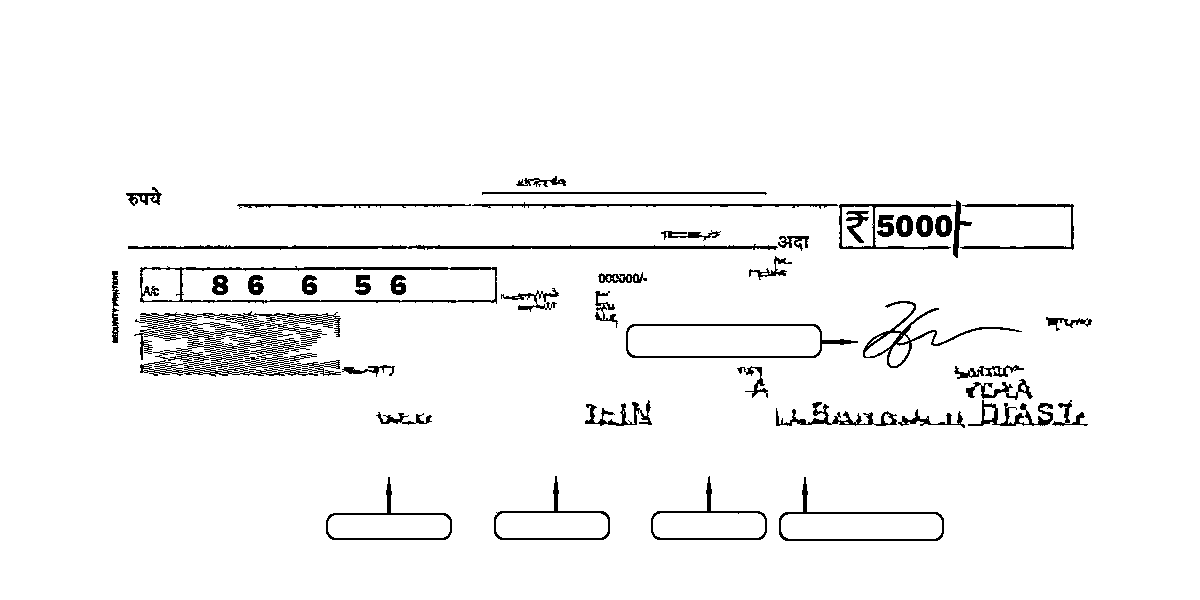

True

In [ ]:
# Area of Text
the_biggest_component = 0
total_area = 0
counter = 0
average = 0.0
for region in regionprops(blobs_labels):
    if (region.area > 0):
        total_area = total_area + region.area
        counter = counter + 1
    if (region.area >= 240):
        if (region.area > the_biggest_component):
            the_biggest_component = region.area
# Threshold
average = (total_area/counter)
print("the_biggest_component: " + str(the_biggest_component))
print("average: " + str(average))

a4_constant = ((average/84.0)*250.0)+100
print("a4_constant: " + str(a4_constant))
# Remove Noise
b = morphology.remove_small_objects(blobs_labels, a4_constant)

plt.imsave('pre_version.png', b)

# read the pre-version
img2 = cv2.imread('pre_version.png', 0)
# ensure binary
img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# save the the result
cv2_imshow(img2)
cv2.imwrite("output.png", img2)

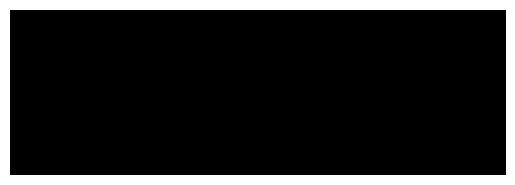

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Assuming `signature_box` contains the bounding box coordinates of the signature region
# `signature_box` should be in the format (x, y, w, h)
signature_box = (14, 7, 3, 1)

# Crop the bottom right part of the image containing the signature
x, y, w, h = signature_box
signature_image = img2[y:y+h, x:x+w]

# Display the cropped signature image using matplotlib
plt.imshow(signature_image, cmap='gray')
plt.axis('off')
plt.show()



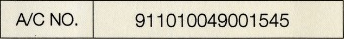

True

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read image
img = cv2.imread('cheque2.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Extract the signature region from the original image
signature = img[y:y+h, x:x+w]

# Display the signature
cv2_imshow(signature)

# Save the signature as a separate image
cv2.imwrite("signature.jpg", signature)


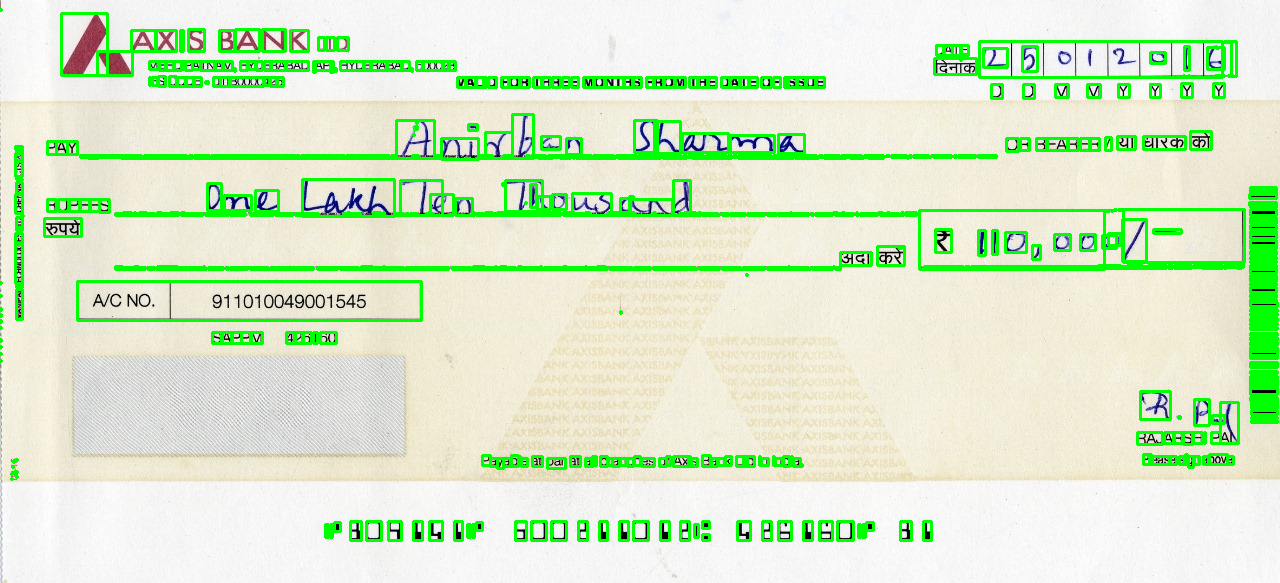

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read image
img = cv2.imread('cheque2.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
cv2_imshow(img)


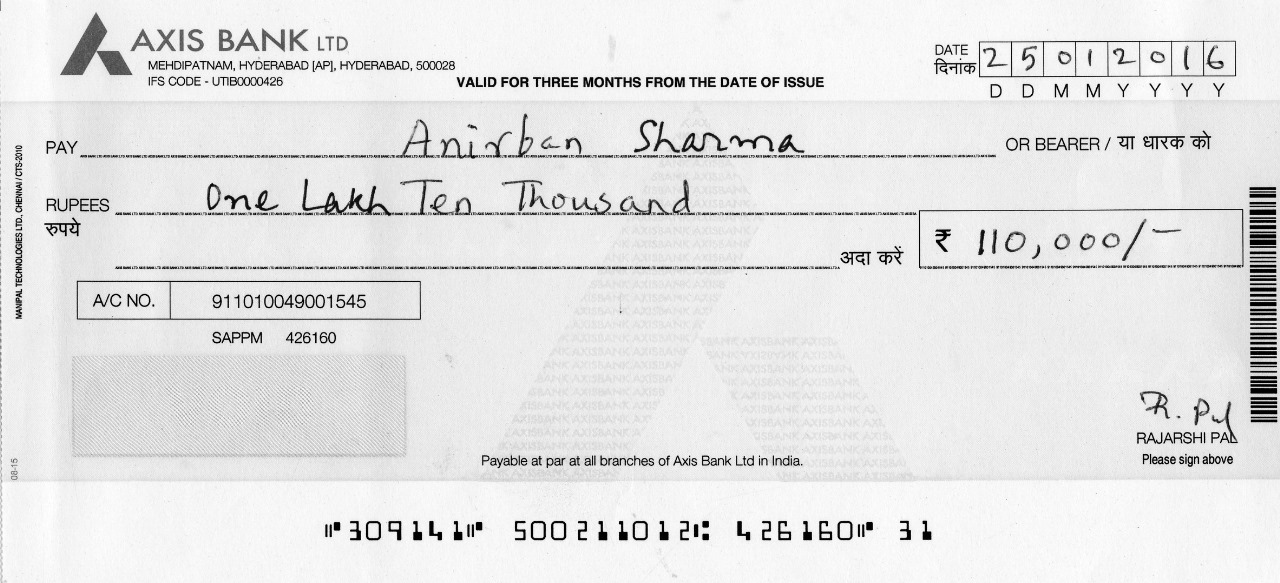

No signature found in the image.


In [ ]:
import cv2
import numpy as np

def aspect_ratio_within_range(contour):
    """
    Checks if the aspect ratio of a contour falls within a desired range.

    Args:
        contour (numpy.ndarray): The contour to be evaluated.

    Returns:
        bool: True if the aspect ratio is within the range, False otherwise.
    """

    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    return 0.2 <= aspect_ratio <= 0.8  # Adjust based on expected signature shapes


def area_within_range(contour):
    """
    Checks if the area of a contour falls within a desired range.

    Returns:
        bool: True if the area is within the range, False otherwise.
    """

    area = cv2.contourArea(contour)
    return 100 < area < 5000  # Adjust based on expected signature sizes


def extract_signature(image_path, display_image=True):
    """
    Extracts the signature from the specified image path, displaying results.

    Args:
        image_path (str): The path to the image containing the cheque.
        display_image (bool, optional): Whether to display the results visually. Defaults to True.

    Returns:
        numpy.ndarray: The extracted signature image (if found), None otherwise.
    """

    # Read the image
    img = cv2.imread(image_path, 0)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # Filter and draw potential signature regions
    potential_signature = None
    for c in cnts:
        if aspect_ratio_within_range(c) and area_within_range(c):
            # Draw a rectangle around the potential signature (green for success, red for potential false positive)
            color = (0, 255, 0) if potential_signature is None else (0, 0, 255)
            cv2.drawContours(img, [c], 0, color, 2)

            # Extract the ROI containing the potential signature
            x, y, w, h = cv2.boundingRect(c)
            signature_roi = thresh[y:y+h, x:x+w]

            # Optional morphological operations (adjust parameters as needed)
            kernel = np.ones((3, 3), np.uint8)
            signature_roi = cv2.erode(signature_roi, kernel, iterations=1)
            signature_roi = cv2.dilate(signature_roi, kernel, iterations=1)

            potential_signature = signature_roi

    # Display results with cv2_imshow for Colab compatibility
    if display_image:
        from google.colab.patches import cv2_imshow
        if potential_signature is not None:
            cv2_imshow(potential_signature)  # Display the extracted signature
        else:
            cv2_imshow(img)  # Show the original image with potential false positives marked

    return potential_signature


# Example usage
image_path = 'cheque2.jpg'
signature = extract_signature(image_path)

if signature is not None:
    print("Signature extracted and displayed.")
else:
    print("No signature found in the image.")


In [ ]:
import cv2
import numpy as np

def extract_signature_with_sift(image_path):
    """
    Extracts the signature from a cheque image using SIFT features.

    Args:
        image_path (str): The path to the cheque image.

    Returns:
        numpy.ndarray: The extracted signature image (if found), None otherwise.
    """

    # Read the cheque image
    cheque_img = cv2.imread(image_path, 0)

    # Create SIFT object
    sift = cv2.SIFT_create()

    # Extract keypoints and descriptors for the entire cheque image
    kp1, des1 = sift.detectAndCompute(cheque_img, None)

    # Ensure reference signature image exists and correct data type
    reference_signature_path = "path/to/reference_signature.jpg"

    try:
        # Attempt to read the reference signature image
        reference_signature_img = cv2.imread(reference_signature_path, 0)

        # Check for successful image reading
        if reference_signature_img is None:
            raise ValueError("Failed to read reference signature image.")

        # Check for correct data type (optional)
        if reference_signature_img.dtype != np.uint8:
            raise ValueError("Reference signature image has incorrect data type.")

    except (FileNotFoundError, ValueError) as e:
        print(f"Error loading reference signature image: {e}")
        return None  # Indicate failure

    # Extract keypoints and descriptors for the reference signature
    kp2, des2 = sift.detectAndCompute(reference_signature_img, None)

    # Match keypoints between the cheque and reference signature
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Filter good matches based on Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append([m])

    # If enough good matches are found, proceed with extracting the region
    if len(good_matches) >= 10:
        src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography matrix
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Apply perspective transformation to extract signature ROI
        signature_height, signature_width = reference_signature_img.shape
        signature_roi = cv2.warpPerspective(cheque_img, M, (signature_width, signature_height))

        return signature_roi

    else:
        return None  # No good matches found

# Example usage
image_path = "cheque2.jpg"
signature_roi = extract_signature_with_sift(image_path)

if signature_roi is not None:
    cv2_imshow(signature_roi)  # Display the extracted signature
else:
    print("Signature not found using SIFT matching.")


Error loading reference signature image: Failed to read reference signature image.
Signature not found using SIFT matching.


In [ ]:
from google.colab import drive
!pip install pytesseract
import pytesseract
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np

!ls -alrt /usr/bin/tesseract

pytesseract.pytesseract.tesseract_cmd = r'usr/bin/tesseract'

image = Image.open('cheque2.jpg')
image

print(pytesseract.image_to_string(image, lang = 'eng'))

!wget 'https://raw.githubsercontent.com/BigPino67/Tesseract-MICR-OCR/master/Tessdata/mcr.traineddata'

!cp mcr.traineddata usr/share/tesseract-ocr/4.00/tessdata/



check_img = cv2.cvtColor(np.array(image),cv2.COLOR_RGB2BGR)
micr_img = check_img[625:717, 0.1630]
check_img.shape

import google.colab.patches
google.colab.patches.cv2_imshow(micr_img)
print(pytesseract.image_to_string(micr_img, lang = 'mcr'))

ls: cannot access '/usr/bin/tesseract': No such file or directory


TesseractNotFoundError: usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.